# Quantum - Comparing Approximate and Exact Quantum Phase Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
from numpy import pi

#importing Qiskit 
from qiskit import IBMQ, Aer 
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute 

#import bacis plot tools 
from qiskit.visualization import plot_histogram 
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error


In [2]:
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx", "cu1"])
    return noise_model


In [3]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the swaps!
    for qubit in range(n//2): # floor division 
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cp(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)


In [4]:
def qft_limited(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            if (j-m) < 3:
                circ.cp(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)

In [5]:
def qpe_n_approx(n, version):
    qubits = n+1
    classicalbits = n
    qpen = QuantumCircuit(qubits, classicalbits)
    
    for qubit in range(n):
        qpen.h(qubit)
    
    qpen.x(n)
    
    angle = 2*math.pi/5
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qpen.cp(angle, counting_qubit, n)
        repetitions *= 2
    
    if version == 1:
        qft_dagger(qpen, n)
    else:
        qft_limited(qpen, n)
    
    qpen.barrier()
    
    for i in range(n):
        qpen.measure(i,i)
        
    return qpen

In [6]:
def qpe_n_exact(n, version):
    qubits = n+1
    classicalbits = n
    qpen = QuantumCircuit(qubits, classicalbits)
    
    for qubit in range(n):
        qpen.h(qubit)
    
    qpen.x(n)
    
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qpen.cp(math.pi/2, counting_qubit, n)
        repetitions *= 2
                
    qpen.barrier()
    
    if version == 1:
        qft_dagger(qpen, n)
    else:
        qft_limited(qpen, n)
    
    qpen.barrier()
    
    for i in range(n):
        qpen.measure(i,i)
        
    return qpen

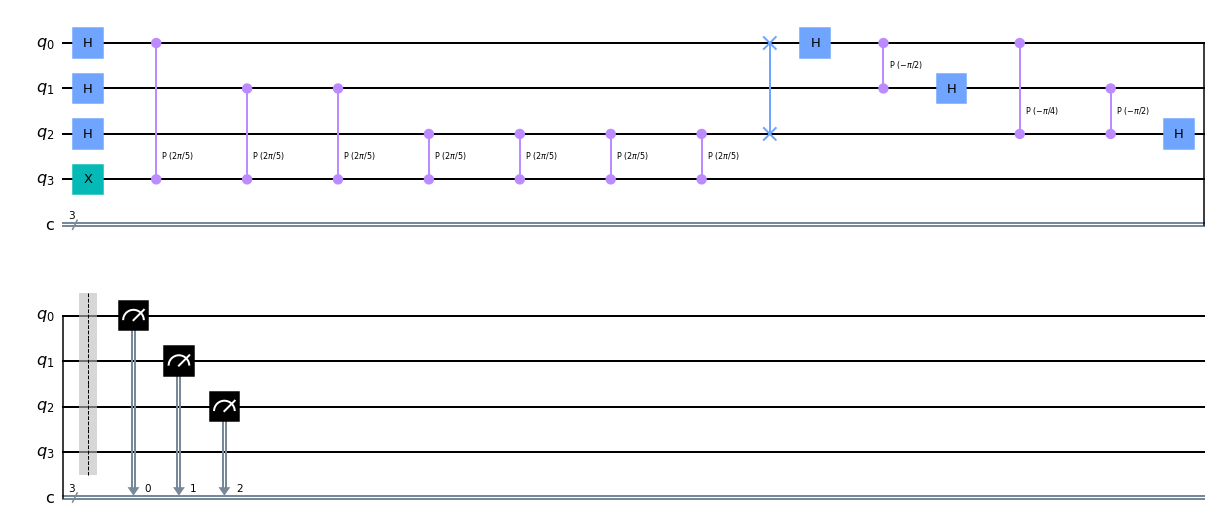

In [7]:
qpen = qpe_n_approx(3, 1)
qpen.draw('mpl')

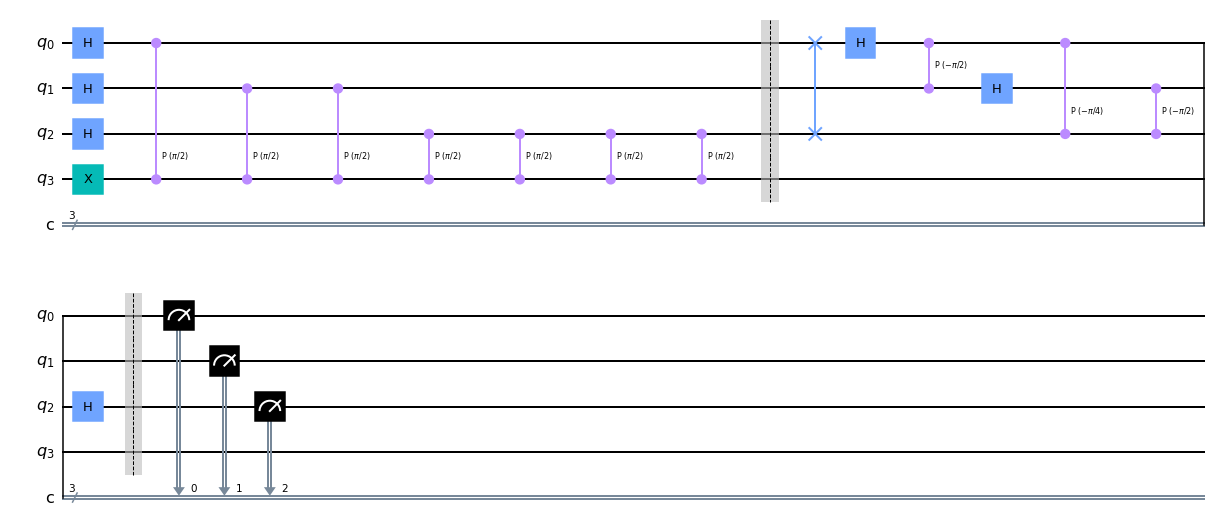

In [8]:
qpen = qpe_n_exact(3, 1)
qpen.draw('mpl')

Peak:  0011001101


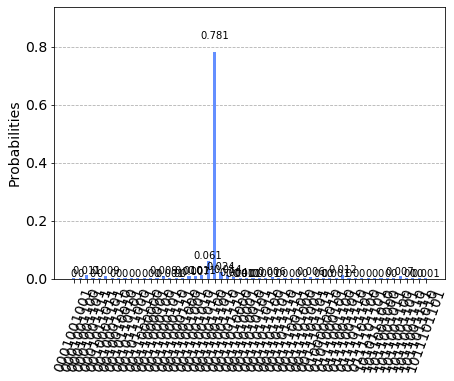

In [9]:
qpen = qpe_n_approx(10, 1)
# noise level, gate noise level 0
noise_model = get_noise(0.01, 0.05)
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpen, backend=backend, shots=shots, noise_model=noise_model).result()
answer = results.get_counts()

max_value = next(iter(answer.values()))
for key,value in answer.items():
    if value > max_value:
        max_value = value  
        max_key = key
print("Peak: ",max_key)


plot_histogram(answer)




## Table 1: Approximate Quantum Phase Estimation with Noise 

| Gate Noise Level | N | Efficiency |    Peak     |
| :----:           | ----:   | :-----:    | ----:      |
|  0.01            |    6     | 0.833      | 001101      | 
|  0.01            |    8     | 0.808      | 00110011    | 
|  0.01            |   10     | 0.803      | 0011001101  |
|  0.05            |    6     | 0.824      | 001101      | 
|  0.05            |    8     | 0.792      | 00110011    | 
|  0.05            |   10     | 0.795      | 0011001101  |

Peak:  0100000000


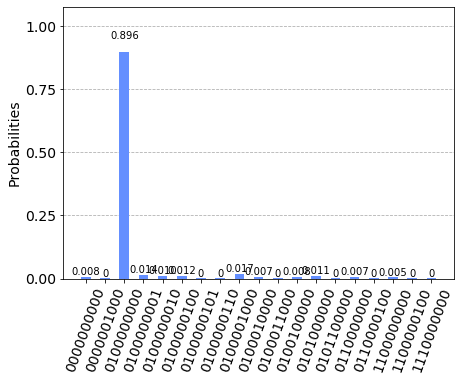

In [10]:
qpen = qpe_n_exact(10, 1)
# noise level, gate noise level 0
noise_model = get_noise(0.01, 0.05)
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpen, backend=backend, shots=shots, noise_model=noise_model).result()
answer = results.get_counts()

max_value = next(iter(answer.values()))
for key,value in answer.items():
    if value > max_value:
        max_value = value  
        max_key = key
print("Peak: ",max_key)

plot_histogram(answer)

## Table 2: Exact Quantum Phase Estimation with Noise 
| Gate Noise Level | N | Efficiency |    Peak     |
| :----:           | ----:   | :-----:    | ----:      |
|  0.01            |    6     | 0.938      | 010000      | 
|  0.01            |    8     | 0.919      | 01000000    | 
|  0.01            |   10     | 0.903      | 0100000000  |
|  0.05            |    6     | 0.950      | 010000      | 
|  0.05            |    8     | 0.925      | 01000000    | 
|  0.05            |   10     | 0.897      | 0100000000  |

Peak:  001101


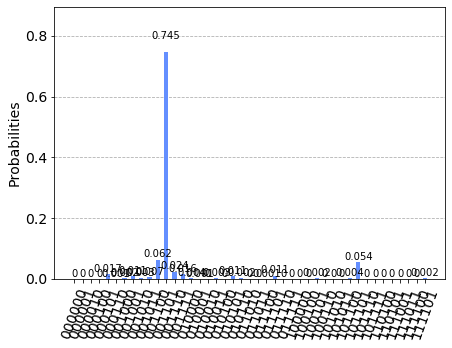

In [11]:
qpen = qpe_n_approx(6, 2)
# noise level, gate noise level 0
noise_model = get_noise(0.01, 0.01)
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpen, backend=backend, shots=shots, noise_model=noise_model).result()
answer = results.get_counts()

max_value = next(iter(answer.values()))
for key,value in answer.items():
    if value > max_value:
        max_value = value  
        max_key = key
print("Peak: ",max_key)


plot_histogram(answer)

## Table 3: Approximate Quantum Phase Estimation with Elimation of Smaller Rotations
| Gate Noise Level | N | Efficiency |    Peak     |
| :----:           | ----:   | :-----:    | ----:      |
|  0.01            |    6     | 0.764      | 001101      | 
|  0.01            |    8     | 0.643      | 00110011    | 
|  0.01            |   10     | 0.605      | 0011001101  |

Peak:  0100000000


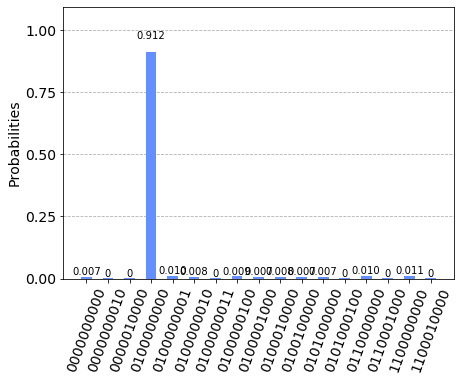

In [12]:
qpen = qpe_n_exact(10, 2)
# noise level, gate noise level 0
noise_model = get_noise(0.01, 0.01)
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpen, backend=backend, shots=shots, noise_model=noise_model).result()
answer = results.get_counts()

max_value = next(iter(answer.values()))
for key,value in answer.items():
    if value > max_value:
        max_value = value  
        max_key = key
print("Peak: ",max_key)

plot_histogram(answer)

## Table 4: Exact Quantum Phase Estimation with Elimation of Smaller Rotations
| Gate Noise Level | N | Efficiency |    Peak     |
| :----:           | ----:   | :-----:    | ----:      |
|  0.01            |    6     | 0.937      | 010000      | 
|  0.01            |    8     | 0.925      | 01000000    | 
|  0.01            |   10     | 0.895      | 0100000000  |

## Conclusions

A n value of 6, 8, 10 was used on two different noise gate levels of 0.01 and 0.05 for both the exact and approximate versions of quantum phase estimation. Then tests were re-run for the removal of smaller rotation but with a single gate noise level. This was the results. 

Table 1: When approximating quantum phase estimation with noise in table 1. I noticed when as n went up with the 0.01 gate noise level the efficiency went down. the results however was not the same when the gate noise level went to 0.05, the efficiency was going down until the last n of 10 it went up, it was higher than the n of 8.
Table 2: When approximating quantum phase estimation with noise in table 2. I noticed when as n went up with the 0.01 gate noise level the efficiency went down. when the gate noise level went to 0.05, the efficiency also went down from high to low as n went up. 
Table 3: When approximating quantum phase estimation with the elimation of smaller rotations in table 3. I noticed when as n went up with the 0.01 gate noise level the efficiency went down. 
Table 4: When exact quantum phase estimation with the elimation of smaller rotations in table 4. I noticed when as n went up with the 0.01 gate noise level the efficiency went down. 
When comparing all of the tables to eachother: when comparing all of the tables to eachother. From table 1 to 2, I noticed that from the approximate to the exact quantum phase estimation the efficiency were higher overall for the exact quantum phase estimation. 
When comparing table 3 to 4 i noticed the exact same pattern of the efficiency going down as n increases. However, table 4 with the exact versus the approximate also had higher efficiency overall. 
For all of the table when looking the exact and the approximate efficiencies the exact ones seem to be overall higher than those of the approximate quantum phase estimation tables. 
When comparing both exacts and both approximates you can see overall the tables with the elimation of smaller rotations has less efficiency compared to their counterparts that do not elimate smaller rotations. 
Result also showed that through out all the differnent noise levels per distinct n the approximate qpe had the same peak as well as the exact qpe. Also both exact qpe's, one with regular qft_dagger and the qft_limited had the same peak and this was the same with both approximates. 
It seems looking back at table 1 and 2 that with the gate noise level that was increased to 0.05 from 0.01, it shows more signs of interference, as in the approximate qpe it showed the n of 10 being higher than the n of 8 with the same gate noise level had the efficiency go up. While as the exact qpe it showed that the efficieny went down for the same gate nosie level of 0.05. 

Overall, with a higher n there should have been more accurate results but this was not the case, even though the peaks for each were correct. This shows that noise does affect our results as with the increase of n, with the increase of noise across table 1 and 2 the results shows a decrease of accuracy where as the increase of n without noise, the results should be more accurate. This shows that noise is in fact affecting the precision of our results. When elimating of smaller rotations of Qft it shows that the results of the approximate qpe decreases whiles the exact qpe stays the same.  